In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import nltk
import contractions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

from sklearn.decomposition import NMF
from sklearn import svm
from sklearn import datasets, metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier


In [2]:
fname = 'Project1-Classification.csv'
df = pd.read_csv (fname)

**EDA**

In [3]:
df.head(5)

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,"'Pure Hockey, the largest hockey retailer in t...","'Pure Hockey, the largest hockey retailer in t...","['acquire', 'agrees', 'nevada', 'retail', 'hoc...",2022-10-21 17:11:22+00:00,['Ein News'],https://www.einnews.com/pr_news/597148062/pure...,hockey,sports
1,'HKO Hockey Canada Sponsorship 20221006\n\nHoc...,'The tally of Hockey Canada’s sponsorship loss...,"['sexual', 'exclusive', 'settlement', 'million...",NaN,['Barbara Shecter'],https://ca.finance.yahoo.com/news/exclusive-ho...,hockey,sports
2,'Canadian Prime Minister Justin Trudeau said W...,'Canadian Prime Minister Justin Trudeau said W...,"['québec', 'surprise', 'trust', 'sexual', 'org...",2022-10-05 00:00:00,['The Athletic Staff'],https://theathletic.com/3659888/2022/10/05/hoc...,hockey,sports
3,'Hockey Canada paid a crisis communications fi...,'Nicholson says that Hockey Canada did not go ...,"['sexual', 'organization', 'million', 'ceo', '...",2022-11-15 00:00:00,['Dan Robson'],https://theathletic.com/3900630/2022/11/15/hoc...,hockey,sports
4,'The Denver Broncos are looking for a new head...,'The Denver Broncos are looking for a new head...,"['beats', 'force', 'season', 'teams', 'anchora...",NaN,"['Parker Seibold', 'The Gazette', 'Gazette File']",https://gazette.com/multimedia/photo-air-force...,hockey,sports


In [4]:
num_sports_article = len(df.loc[df.root_label == 'sports'])
print("# article with root label == sports =", num_sports_article)
num_climate_article = len(df.loc[df.root_label == 'climate'])
print("# article with root label == climate =", num_climate_article)
print("# total article = ",len(df))
print("Row samples: {}, features: {}, \n".format(df.shape[0], df.shape[1]))

# article with root label == sports = 1750
# article with root label == climate = 1400
# total article =  3150
Row samples: 3150, features: 8, 



In [5]:
FT = df.full_text

In [6]:
FT.head()

0    'Pure Hockey, the largest hockey retailer in t...
1    'HKO Hockey Canada Sponsorship 20221006\n\nHoc...
2    'Canadian Prime Minister Justin Trudeau said W...
3    'Hockey Canada paid a crisis communications fi...
4    'The Denver Broncos are looking for a new head...
Name: full_text, dtype: object

In [7]:
import re
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Frequency of each root label')

<Figure size 432x288 with 0 Axes>

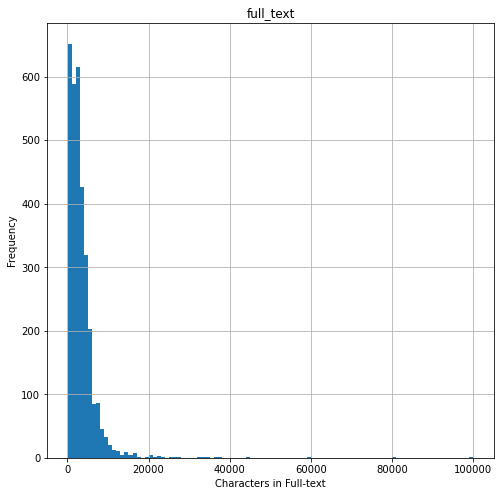

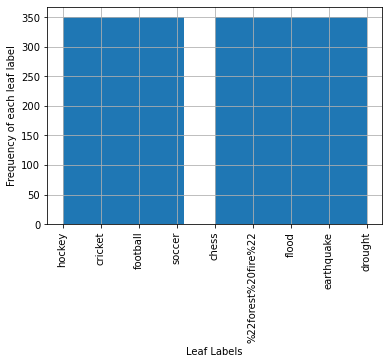

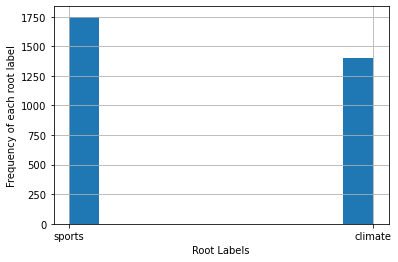

In [8]:
plt.figure()
pd.DataFrame(df['full_text'].apply(lambda x: len(x))).hist(bins=100, figsize= (8, 8))
plt.xlabel("Characters in Full-text")
plt.ylabel("Frequency")


plt.figure()
df['leaf_label'].hist(xrot=90)
plt.xlabel("Leaf Labels")
plt.ylabel("Frequency of each leaf label")


plt.figure()
df['root_label'].hist()
plt.xlabel("Root Labels")
plt.ylabel("Frequency of each root label")

### Q1
a) Row samples: 3150, features: 8 <br>
b) All the graph are plotted in the above cell <br>
c)
 

1.   Graph1 : frequency vs charracter in full text . Some of the character have quite high frequency while some have very low frequency. The distribution in general follows gaussian distribution.
2.   Graph2 : No. of articles vs Leaf labels . we see that sample are evenly distributed into leaf labels with each category having around 350 samples.
3. Graph3 : No. of articles vs Root labels. we see that sample are not evenly distributed in root label and sports category have higher frequency than climate one.



# Binary Classification

In [9]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

### train test split

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

In [11]:
print("train set size  = ",len(train))
print("test set size  = ",len(test))

train set size  =  2520
test set size  =  630


### Q2 
**Training dataset size**: 2520

**Test dataset size**: 630

### Define Stopwords

In [12]:
# To clean HTML text

"""
- HTML artifacts removal
- Links removal
- quotes removal
- Special characters removal
- Extra spaces removal
- Changing the short forms to full forms using contractions
- Punctuations removal
- Changing all text to lower case
"""

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r'http\S+', '', text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    texter = texter.strip()
    texter = contractions.fix(texter)
    texter = re.sub('''[!"#$%&'()*+,/;:-<=>?@[\]^_`{|}~-]''', '', texter)
    texter = texter.lower()
    texter = re.sub(' +', ' ', texter)
    if texter == "":
        texter = ""
    return texter

### Feature Extraction

In [13]:
# Function to get POS Tag
def get_pos_tags(nltkTag):
    firstChar = nltkTag[0]
    if firstChar == 'J':
        return wordnet.ADJ
    if firstChar == 'S':
        return wordnet.ADJ_SAT
    if firstChar == 'V':
        return wordnet.VERB
    if firstChar == 'N':
        return wordnet.NOUN
    if firstChar == 'R':
        return wordnet.ADV
    return wordnet.NOUN


In [14]:
# Function to lemmatize each sentence, along with stripping extra spaces, full stops and numbers.
def lemmatize(text):
    tokens = nltk.word_tokenize(text)
    posTags = nltk.pos_tag(tokens)
    tags = [get_pos_tags(w[1]) for w in posTags]
    lemmas = [lemmatizer.lemmatize(tokens[i], tags[i]) for i in range(0, len(tokens))]
    lemmas = ' '.join(lemmas)
    lemmas = re.sub(r'\w*\d\w*', '', lemmas)
    lemmas = re.sub('[.]', '', lemmas)
    lemmas = re.sub(' +', ' ', lemmas).strip()
    return lemmas

In [15]:
#  Function to stem the sentence along with stripping extra spaces, full stops and numbers.
def stemmer(text):
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(tokens[i]) for i in range(0, len(tokens))]
    stems = ' '.join(stems)
    stems = re.sub(r'\w*\d\w*', '', stems)
    stems = re.sub('[.]', '', stems)
    stems = re.sub(' +', ' ', stems).strip()
    return stems

In [16]:
# Whole preprocessing pipeline with lemmatization
def preprocess(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [lemmatize(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

In [17]:
# Whole preprocessing pipeling with stemming
def preprocessStem(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [stemmer(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

# Preprocessing pipeline with cleaning but without any compression
def preprocessNoCompress(sample):
    sample = clean(sample)
    return sample


# Preprocessing with lemmatization but no cleaning
def preprocessNC(sample):
    sample = sample.split('.')
    sample = [lemmatize(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

# Preprocessing with stemming but no cleaning
def preprocessStemNC(sample):
    sample = sample.split('.')
    sample = [stemmer(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

# Preprocessing without any compression or cleaning
def preprocessNoCompressNC(sample):
    return sample

In [18]:
# Initializations
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

stopWords = set(stopwords.words('English'))

### Pipeline for count vector and Tf-idf

In [19]:
# Feature Extraction using CountVectorizer and TF-IDF transformation using Pipeline.
featurePipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
]).fit(train['full_text'])

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [20]:
#  TF-IDF processed train and test matrices.
train_tfidf = featurePipeline.transform(train['full_text'])
test_tfidf = featurePipeline.transform(test['full_text'])

print(" Training data TF-IDF Matrix size: {}".format(train_tfidf.shape))
print("Testing data TF-IDF Matrix size: {}".format(test_tfidf.shape))

 Training data TF-IDF Matrix size: (2520, 14060)
Testing data TF-IDF Matrix size: (630, 14060)


### Q3
a). Pros of Lemmatization:

* Lemmatization tries to incorporate the contextual information of the word. 

* The word's lemma can change depending on the context, which is highly helpful if differentiating in the context of two sentences using the same words.

* Lemmatization can capture the semantic meaning of words in which it is used in a sentence.

Cons of Lemmatization:

* Lemmatization requires a large corpus size to get the lemma of a word as it anlyzes the form and context inwhich it is used. Stemming merely uses the word and attempts to identify its stem by trimming from the front or back of the word in accordance with language-based rules.
* The runtime of lemmatization is slower compared to stemming.

b). On increasing min_df(minimum document frequency) the tf-idf size also reduces as generally not all the word ppresent equally likely in the corpus, so the word which frequency lower than min_df are dropped as a result of which representation vector for each sample also reduces.

c). It is recommended to remove stopword before lemmatization, As lematization might change the stopword and change word might not be present in the list of stopwrods being removed, thus being present in the corpus although it doesn't make any sense. However if we are using word2vec, GLoVE or any Neural Network based lemmatizer which take entire sentence as input to generate vector representation of a word, removal of stopwords can make a difference in the way these embeddings occupy the vector space since stopwords do contribute to some context and semantic meaning to the whole sentence. <br>
It is recommended to remove punctuation in the starting as lemmatizer uses words as input and punctutations don't fall into a word category so they are quite useless. <br>
Numbers can be removed before or after lemmatizing since they are just numerals and dont really have a lemma

d). Training data TF-IDF Matrix size: (2520, 14060) Testing data TF-IDF Matrix size: (630, 14060)

    No. of columns: (k * 10^3) where k ~ 14.1


### Dimensionality Reduction

In [21]:
"""
Functions to get the trained SVD and NMF model
"""

def getSVD(n_comp, data):
    SVD = TruncatedSVD(n_components=n_comp, random_state=42)
    SVD.fit(data)
    return SVD

# NMF Non-negative Matrix Factorization
def getNMF(n_comp, data):
    NMFmodel = NMF(n_components=n_comp, init='random', random_state=42)
    NMFmodel.fit(data)
    return NMFmodel

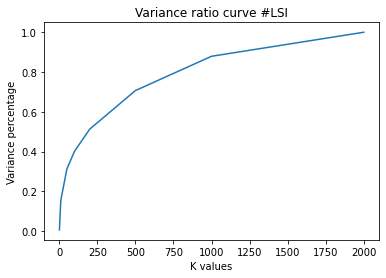

In [22]:
# Plotting variance graph
k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]
variance_ratio = []
reconstructionErrors = []

for i in range(0, len(k_values)):
    SVD = getSVD(k_values[i], train_tfidf)
    variance_ratio.append(SVD.explained_variance_ratio_.sum())
    transformed = SVD.transform(train_tfidf)
    reconstruct = SVD.inverse_transform(transformed)
    reconstructionErrors.append(np.linalg.norm((train_tfidf.toarray() - reconstruct), 'fro') ** 2)
    
plt.plot(k_values, variance_ratio)
plt.xlabel("K values")
plt.ylabel("Variance percentage")
plt.title("Variance ratio curve #LSI")
plt.show()

In [23]:
k = 50
NMFdecomp = getNMF(k, train_tfidf)

In [24]:
# Reconstruction Errors
reconstructedLSIError = reconstructionErrors[2]
reconstructedNMFError = (NMFdecomp.reconstruction_err_)**2

print("Reconstruction residual MSE error for LSI:: {}".format(reconstructedLSIError))
print("Reconstruction residual MSE error for NMF:: {}".format(reconstructedNMFError))

Reconstruction residual MSE error for LSI:: 1676.2833351717513
Reconstruction residual MSE error for NMF:: 1700.1396788381137


### Q4
a). The variance ratio plot for LSI resembles a transitory curve that grows exponentially before saturating.This curve is concave. The concavity of the plot shows that projections along the initial singular vectors, which correspond to the biggest eigenvalues, capture the majority of the variance and that the rest of the data contains more noise and less useful information.

b).
Reconstruction residual MSE error for LSI =  1676.2833351717513 <br>
Reconstruction residual MSE error for NMF = 1700.1396788381137  <br>
Reconstruction residual MSE error for LSI is smaller compared to that from NMF. <br>

NMF tries to identify the key elements that accurately depict the data. As NMF is generally not attempting to reconstruct the original data but rather to identify key features that may be combined to obtain the entire dataset, it is understandable that the reconstruction error for NMF is a bit higher.

For LSI, it works on projecting data to eigen vectors which capture most variance i.e they try to retain most of the data. So LSI's aim to get back the original data. Therefore LSI better in data reconstruction. 

# Classification Algorithm

In [25]:
k_feat = 500
train_labels = np.array((train['root_label'] == 'climate').astype('int'))
test_labels = np.array((test['root_label'] == 'climate').astype('int'))

SVDK500 = getSVD(k_feat, train_tfidf)
trainDataK500 = SVDK500.transform(train_tfidf)
testDataK500 = SVDK500.transform(test_tfidf)

In [26]:
#Hard Linear SVM
HardSVMModel = svm.SVC(kernel='linear', C = 1000)
HardSVMModel.fit(trainDataK500, train_labels)
predictionsHard = HardSVMModel.predict(testDataK500)

# Gamma = 100000
GammaSVMModel = svm.SVC(kernel='linear', C = 100000)
GammaSVMModel.fit(trainDataK500, train_labels)
predictionsGamma = GammaSVMModel.predict(testDataK500)



In [27]:
#Soft Linear SVM
SoftSVMModel = svm.SVC(kernel='linear', C = 0.0001)
SoftSVMModel.fit(trainDataK500, train_labels)
predictionsSoft = SoftSVMModel.predict(testDataK500)

In [43]:
def getScores(y_true, y_pred):
    y_true = y_true.reshape((-1))
    y_pred = y_pred.reshape((-1))
#     confusion_matrix = metrics.confusion_matrix(y_true.reshape((-1)), y_pred.reshape((-1)))
#     tn, fp, fn, tp = metrics.confusion_matrix(y_true.reshape((-1)), y_pred.reshape((-1))).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
    recall = recall_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
    f1 = f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
    
    return {
        'confusion_matrix': confusion_matrix,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

svmScores = {
    'HardSMV': {
        'climate': {
            'scores': getScores(test_labels, predictionsHard)
        },
        'sports': {
            'scores': getScores(1 - test_labels, 1 - predictionsHard)
        }
    },
    'HighGammaSVM': {
        'climate': {
            'scores': getScores(test_labels, predictionsGamma)
        },
        'sports': {
            'scores': getScores(1 - test_labels, 1 - predictionsHard)
        }
    },
    'SoftSVM': {
        'climate': {
            'scores': getScores(test_labels, predictionsSoft)
        },
        'sports': {
            'scores': getScores(1 - test_labels, 1 - predictionsHard)
        }
    }
}

In [44]:
# 5-Fold cross validation to find optimal gamma.
def avgKFoldError(clf, train, y):
    kf = KFold(n_splits=5)
    error = 0
    for train_idx, test_idx in kf.split(train):
        x_train, x_test = train[train_idx], train[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        clf.fit(x_train, y_train)
        predictions = clf.predict(x_test)
        error = error + sum(np.abs(predictions - y_test))
    
    return error / kf.n_splits

In [45]:
# 5-Fold cross validation to find optimal gamma.
def avgKFoldError(clf, train, y):
    kf = KFold(n_splits=5)
    error = 0
    for train_idx, test_idx in kf.split(train):
        x_train, x_test = train[train_idx], train[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        clf.fit(x_train, y_train)
        predictions = clf.predict(x_test)
        error = error + sum(np.abs(predictions - y_test))
    
    return error / kf.n_splits

In [61]:
gammas = np.linspace(-3,6,10)
bestGamma = -1
minError = np.infty
bestSVM = None
for gamma in gammas:
    SVMk = svm.SVC(kernel='linear', C=(10**gamma))
    err = avgKFoldError(SVMk, trainDataK500, train_labels)
    print(err, SVMk)
    if err <= minError:
        minError = err
        bestGamma = 10**gamma
        bestSVM = SVMk

# Training best SVM
bestSVM.fit(trainDataK500, train_labels)
bestSVMPred = bestSVM.predict(testDataK500)

scores = getScores(test_labels, bestSVMPred)

227.4 SVC(C=0.001, kernel='linear')
227.0 SVC(C=0.01, kernel='linear')
28.2 SVC(C=0.1, kernel='linear')
21.4 SVC(kernel='linear')
27.6 SVC(C=10.0, kernel='linear')
29.6 SVC(C=100.0, kernel='linear')
29.8 SVC(C=1000.0, kernel='linear')
29.8 SVC(C=10000.0, kernel='linear')
29.8 SVC(C=100000.0, kernel='linear')
29.8 SVC(C=1000000.0, kernel='linear')


#### Hard SVM

In [47]:
print("Scores for Hard SVM Model: {}\n".format(HardSVMModel))
print("Accuracy: ", getScores(test_labels, predictionsHard)['accuracy'])
print("Precision: ", getScores(test_labels, predictionsHard)['precision'])
print("Recall Score: ", getScores(test_labels, predictionsHard)['recall'])
print("F1 Score: ", getScores(test_labels, predictionsHard)['f1'])

Scores for Hard SVM Model: SVC(C=1000, kernel='linear')

Accuracy:  0.9714285714285714
Precision:  0.9716951349220243
Recall Score:  0.9714285714285714
F1 Score:  0.9714719491035282


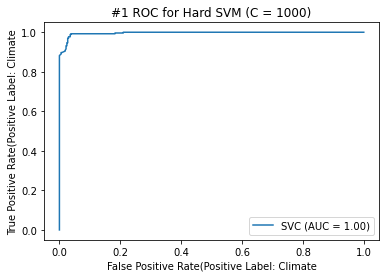

In [48]:
metrics.plot_roc_curve(HardSVMModel,testDataK500, test_labels)
plt.title("#1 ROC for Hard SVM (C = 1000)")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

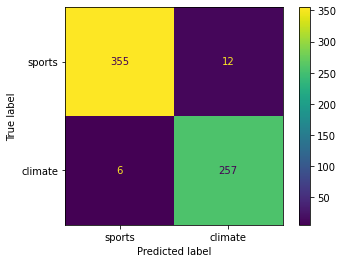

In [49]:
plot_confusion_matrix(HardSVMModel, testDataK500, test_labels, display_labels=['sports', 'climate'])

#### Extreme Hard SVM (γ = 100000)

In [50]:
print("\n\nScores for Extreme Hard Classifier: {}\n".format(GammaSVMModel))
print("Accuracy: ", getScores(test_labels, predictionsGamma)['accuracy'])
print("Precision: ", getScores(test_labels, predictionsGamma)['precision'])
print("Recall Score: ", getScores(test_labels, predictionsGamma)['recall'])
print("F1 Score: ", getScores(test_labels, predictionsGamma)['f1'])



Scores for Extreme Hard Classifier: SVC(C=100000, kernel='linear')

Accuracy:  0.9714285714285714
Precision:  0.9716951349220243
Recall Score:  0.9714285714285714
F1 Score:  0.9714719491035282


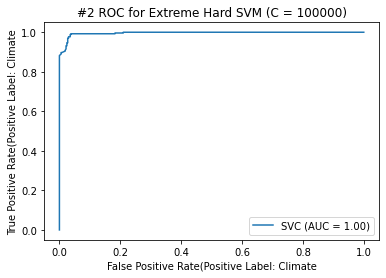

In [51]:
metrics.plot_roc_curve(GammaSVMModel,testDataK500, test_labels)

plt.title("#2 ROC for Extreme Hard SVM (C = 100000)")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")

plt.show()

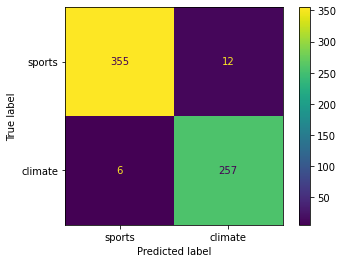

In [52]:
plot_confusion_matrix(GammaSVMModel, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

#### Soft SVM

In [53]:
print("Scores for Soft SVM Model: {}\n".format(SoftSVMModel))
print("Accuracy: ", getScores(test_labels, predictionsSoft)['accuracy'])
print("Precision: ", getScores(test_labels, predictionsSoft)['precision'])
print("Recall Score: ", getScores(test_labels, predictionsSoft)['recall'])
print("F1 Score: ", getScores(test_labels, predictionsSoft)['f1'])

Scores for Soft SVM Model: SVC(C=0.0001, kernel='linear')

Accuracy:  0.5825396825396826
Precision:  0.5825396825396826
Recall Score:  1.0
F1 Score:  0.7362086258776329


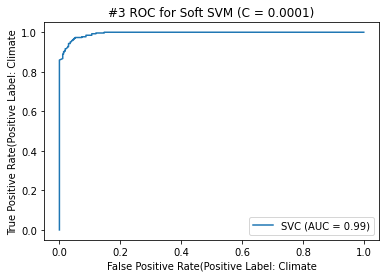

In [54]:
metrics.plot_roc_curve(SoftSVMModel,testDataK500, test_labels)
plt.title("#3 ROC for Soft SVM (C = 0.0001)")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()


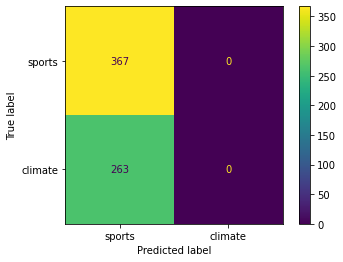

In [60]:
plot_confusion_matrix(SoftSVMModel, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

#### Best SVM

In [62]:
print("\n\nScores for Best SVM Classifier after 5-Fold cross validation: {}\n".format(bestSVM))
print("Accuracy: ", getScores(test_labels, bestSVMPred)['accuracy'])
print("Precision: ", getScores(test_labels, bestSVMPred)['precision'])
print("Recall Score: ", getScores(test_labels, bestSVMPred)['recall'])
print("F1 Score: ", getScores(test_labels, bestSVMPred)['f1'])



Scores for Best SVM Classifier after 5-Fold cross validation: SVC(kernel='linear')

Accuracy:  0.9682539682539683
Precision:  0.9686977450753418
Recall Score:  0.9682539682539683
F1 Score:  0.9683168569787569


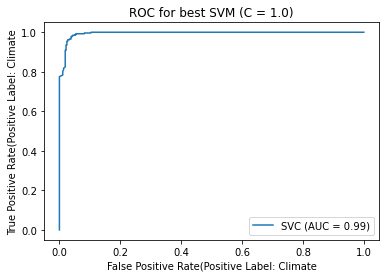

In [63]:
metrics.plot_roc_curve(bestSVM, testDataK500, test_labels)
plt.title("ROC for best SVM (C = {})".format(bestGamma))
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

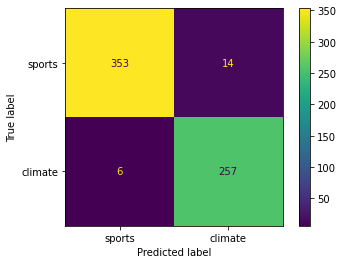

In [59]:
plot_confusion_matrix(bestSVM, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

## Q5
**a)**. By Analyzing the metric for Linear SVM with γ = 0.0001 and γ = 1000, Linear SVM with γ = 1000 performs better.It has accuracy of around 97.14 % on test data with 12 False Positive and 6 False Negative where as Soft SVM has an accuracy of about 58.25 %.

For extreme hard margin SVM with γ = 100000, we see the results are very close to that of gamma = 1000 which indicates that the data is seprable with quite large margin.

Accuracy metric for all the case is mentioned below 

Scores for Hard SVM Model: SVC(C=1000, kernel='linear')


    Accuracy:  0.9714285714285714
    Precision:  0.9716951349220243
    Recall Score:  0.9714285714285714
    F1 Score:  0.9714719491035282

Scores for Extreme Hard Classifier: SVC(C=100000, kernel='linear')

    Accuracy:  0.9714285714285714
    Precision:  0.9716951349220243
    Recall Score:  0.9714285714285714
    F1 Score:  0.9714719491035282
Scores for Soft SVM Model: SVC(C=0.0001, kernel='linear')

    Accuracy:  0.5825396825396826
    Precision:  0.5825396825396826
    Recall Score:  1.0
    F1 Score:  0.7362086258776329
**b).** The soft SVM with γ = 0.0001 performs very poorly with low precision and accuracy as the penalty for misclassification is quite low. From the the confusion it can be seen that all data points are predicted as sport label.

When compared to all other SVMs, the Soft SVM's ROC curve has the least area under the curve. Although the ROC curve appears to be flawless and has a high AUC therfore we cannot only rely on it. It has a very low operating threshold at which it performs well.

**c).** Using 5-Fold Cross Validation, the best value of gamma = C = 1.0, with average number of missclassifications per fold = 21. Its confusion matrix and ROC curves are plotted above.

Scores for Best SVM Classifier after 5-Fold cross validation: SVC(kernel='linear')

    Accuracy:  0.9682539682539683
    Precision:  0.9686977450753418
    Recall Score:  0.9682539682539683
    F1 Score:  0.9683168569787569

### Logistic Regression

In [64]:
logisticNoReg = LogisticRegression(random_state=42, C=100000, max_iter=5000).fit(trainDataK500, train_labels)
logisticNoRegPred = logisticNoReg.predict(testDataK500)
logisticNoRegScores = getScores(test_labels, logisticNoRegPred)

----------------------------------------------------------------------------------------------------
Metrics for best L1 Logistic classifier without regularization
{'confusion_matrix': <function confusion_matrix at 0x7fdb57545820>, 'accuracy': 0.973015873015873, 'precision': 0.9735390292057232, 'recall': 0.973015873015873, 'f1': 0.9730753546235339}


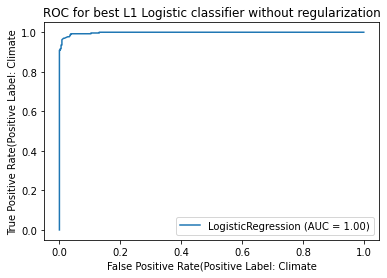

In [68]:
print("-"*100)
print("Metrics for best L1 Logistic classifier without regularization")
print(logisticNoRegScores)

metrics.plot_roc_curve(logisticNoReg, testDataK500, test_labels)
plt.title("ROC for best L1 Logistic classifier without regularization")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

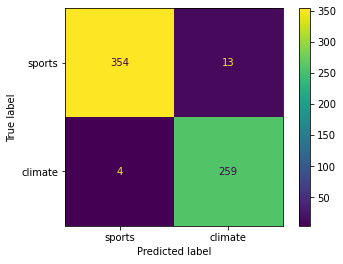

In [69]:
plot_confusion_matrix(logisticNoReg, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

#### L1 regularization

Avg. no. of misclassification:  227.4 LogisticRegression(C=1e-05, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  227.4 LogisticRegression(C=0.0001, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  227.4 LogisticRegression(C=0.001, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  227.4 LogisticRegression(C=0.01, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  37.0 LogisticRegression(C=0.1, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  23.4 LogisticRegression(max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  20.4 LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=4

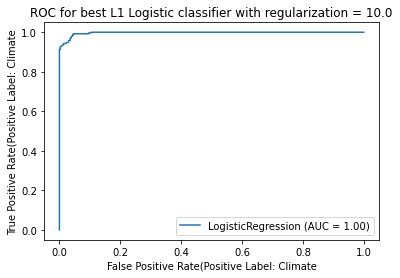

In [66]:
logRegs = np.linspace(-5,5,11)
bestRegL1 = -1
minL1Error = np.infty
bestL1Model = None
for reg in logRegs:
    clfLog = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=10**reg, max_iter=5000)
    err = avgKFoldError(clfLog, trainDataK500, train_labels)
    print("Avg. no. of misclassification: ", err, clfLog)
    if err <= minL1Error:
        minL1Error = err
        bestRegL1 = 10**reg
        bestL1Model = clfLog

# Training best L1 Logistic classifier
bestL1Model.fit(trainDataK500, train_labels)
bestL1Pred = bestL1Model.predict(testDataK500)

L1scores = getScores(test_labels, bestL1Pred)
print("-"*100)
print("Metrics for best L1 Logistic classifier with regularization = {}".format(bestRegL1))
print(L1scores)

metrics.plot_roc_curve(bestL1Model, testDataK500, test_labels)
plt.title("ROC for best L1 Logistic classifier with regularization = {}".format(bestRegL1))
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()


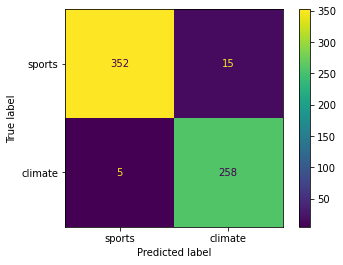

In [70]:
plot_confusion_matrix(bestL1Model, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

#### L2 regularization 

Avg. no. of misclassification:  227.4 LogisticRegression(C=1e-05, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  227.4 LogisticRegression(C=0.0001, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  227.4 LogisticRegression(C=0.001, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  135.4 LogisticRegression(C=0.01, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  33.8 LogisticRegression(C=0.1, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  21.4 LogisticRegression(max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  20.6 LogisticRegression(C=10.0, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  22.6 LogisticRegression(C=100.0, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  24.0 LogisticRegression(C=1000.0, max_it

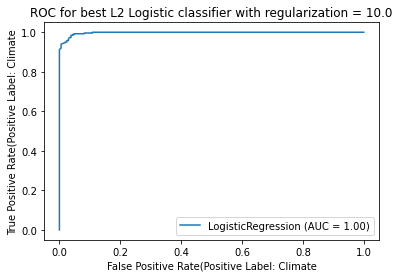

In [67]:
bestRegL2 = -1
minL2Error = np.infty
bestL2Model = None
for reg in logRegs:
    clfLog = LogisticRegression(penalty='l2', random_state=42, C=10**reg, max_iter=5000, solver='liblinear')
    err = avgKFoldError(clfLog, trainDataK500, train_labels)
    print("Avg. no. of misclassification: ", err, clfLog)
    if err <= minL2Error:
        minL2Error = err
        bestRegL2 = 10**reg
        bestL2Model = clfLog

# Training best L2 Logistic classifier
bestL2Model.fit(trainDataK500, train_labels)
bestL2Pred = bestL2Model.predict(testDataK500)

L2scores = getScores(test_labels, bestL2Pred)
print("-"*100)
print("Metrics for best L2 Logistic classifier with regularization = {}".format(bestRegL1))
print(L2scores)

metrics.plot_roc_curve(bestL2Model, testDataK500, test_labels)
plt.title("ROC for best L2 Logistic classifier with regularization = {}".format(bestRegL2))
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

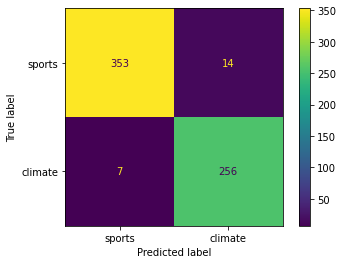

In [71]:
plot_confusion_matrix(bestL2Model, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

### Q6

**a).** The ROC curve and condusion matrix for Logistic Regression without regularization are shown above. The scores for the same on testing set are as follows:

    Accuracy: 0.973015873015873 
    Precision: 0.9735390292057232 
    Recall Score: 0.97301587301587
    F1 Score: 0.9730753546235339
**b).** The optimal L1 regularization strength which is obtained after performing 5-fold cross validation on dimension reduced by SVD data is: C = 10.0 which is equal to 0.1 regularization strength. Solver = 'liblinear'

    Accuracy: 0.9682539682539683
    Precision: 0.968903800836574
    Recall Score: 0.9682539682539683
    F1 Score: 0.9683308660590758
The optimal L2 regularization strength which is obtained after performing 5-fold cross validation on dimension reduced by SVD data is: C = 10.0 which is equal to 0.1 regularization strength. Solver = 'liblinear'

    Accuracy: 0.9666666666666667
    Precision: 0.9670267489711935
    Recall Score: 0.9666666666666667
    F1 Score: 0.9667250766254357
**c).** 
 Below are the avg no. of missclassification for L! regularization at different parameter --
 
    Avg. no. of misclassification:  227.4         C=1e-05
    Avg. no. of misclassification:  227.4         C=0.0001
    Avg. no. of misclassification:  227.4         C=0.001
    Avg. no. of misclassification:  135.4         C=0.01
    Avg. no. of misclassification:  37.0          C=0.1
    Avg. no. of misclassification:  21.4          C=1.0
    Avg. no. of misclassification:  20.6          C=10.0
    Avg. no. of misclassification:  22.6          C=100.0
    Avg. no. of misclassification:  24.4          C=1000.0
    Avg. no. of misclassification:  30.8          C=10000.0
    Avg. no. of misclassification:  36.0          C=100000.0

For L2 regularizer 

    Avg. no. of misclassification:  227.4         C=1e-05
    Avg. no. of misclassification:  227.4         C=0.0001
    Avg. no. of misclassification:  227.4         C=0.001
    Avg. no. of misclassification:  227.4         C=0.01
    Avg. no. of misclassification:  33.8          C=0.1
    Avg. no. of misclassification:  23.4          C=1.0
    Avg. no. of misclassification:  20.4          C=10.0
    Avg. no. of misclassification:  22.6          C=100.0
    Avg. no. of misclassification:  24.0          C=1000.0
    Avg. no. of misclassification:  25.8          C=10000.0
    Avg. no. of misclassification:  26.8          C=100000.0

From the above account we can see that the test error first decreases with the increase in regularization parameter from 0.0001 till 10 where it achieves its minima and then the test error increases with the increase in regularization parameter.

Effect of regularization on the learned coefficients <br>
-->The effect of features is significantly diminished as the regularization value is increased, and as the regularization parameter is increased further, the model becomes overly relaxed and begins to perform worse due to high underfitting as features only represent a straight line with zero slope.

-->Since L2 penalizes errors more, it is used when the data is clean and there aren't many outliers. L2 is also used when all features should be taken into account because L2 regularization doesn't aid in feature selection.

-->When one is unsure about the important feature we can use L1 regularizer as in case of L1 regularizer Unimportant feature weights are assigned to 0. L1 regularizer can also be used when there are alot of outlier.

    
**d).**
SVM and logistic regression are pretty similar to one another in that they both use a linear decision boundary to categorize the data. SVM employs a geometrical/deterministic method, whereas logistic regression uses a probability-based technique. While SVM seeks to identify a decision boundary or separating hyperplane that optimizes the distance between the dividing hyperplace, logistic regression seeks to identify the probability in favor of a class. Because SVM incorporates the concept of margins, their performances vary. When the data is completely linearly separable the results are very much comparable for both but when its' not the case, the gamma parameter in SVM's decides the difference in results between Logistic and SVM.

Additionally, SVMs perform better when the data contains more features than the training examples since they used the Kernelization method to escape the dimensionality curse, whereas Logistic Regression does not. Additionally, SVM can fit non-linear decision bounds while LR cannot.

With the above data in hand, Logistic Regression seems to perform better having 97.3 % accuracy compared to that of 97.1% of SVM's.




### Naive Bayes Model

In [72]:
# Gaussian Naive Bayes Model
GaussianNBModel = GaussianNB()
GaussianNBModel.fit(trainDataK500, train_labels)
gaussianNBPred = GaussianNBModel.predict(testDataK500)
gaussianNBScores = getScores(test_labels, gaussianNBPred)

In [73]:
print("Scores for Gaussian Naive Bayes Classifier : {}\n".format(GaussianNBModel))
print("Accuracy: ", gaussianNBScores['accuracy'])
print("Precision: ", gaussianNBScores['precision'])
print("Recall Score: ", gaussianNBScores['recall'])
print("F1 Score: ", gaussianNBScores['f1'])

Scores for Gaussian Naive Bayes Classifier : GaussianNB()

Accuracy:  0.9365079365079365
Precision:  0.9393953482740668
Recall Score:  0.9365079365079365
F1 Score:  0.9368014955237132


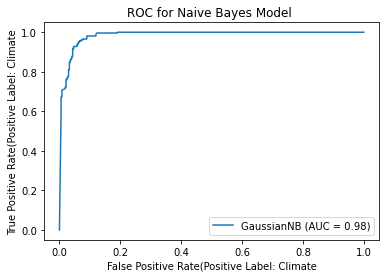

In [75]:
metrics.plot_roc_curve(GaussianNBModel, testDataK500, test_labels)
plt.title("ROC for Naive Bayes Model ")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

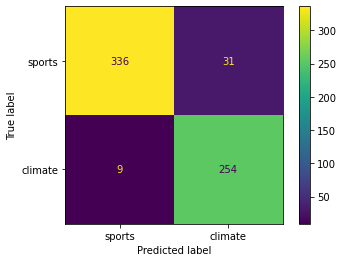

In [74]:
plot_confusion_matrix(GaussianNBModel, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

### Q7)

**a).** Scores for Gaussian Naive Bayes Classifier : GaussianNB() <br>
    Accuracy:  0.9365079365079365 <br>
    Precision:  0.9393953482740668 <br>
    Recall Score:  0.9365079365079365 <br>
    F1 Score:  0.9368014955237132 <br>

### Grid Search of Parameter

In [ ]:
import itertools
def make_param_grids(steps, param_grids):

    final_params=[]

    # Itertools.product will do a permutation such that 
    # (pca OR svd) AND (svm OR rf) will become ->
    # (pca, svm) , (pca, rf) , (svd, svm) , (svd, rf)
    for estimator_names in itertools.product(*steps.values()):
        current_grid = {}

        # Step_name and estimator_name should correspond
        # i.e preprocessor must be from pca and select.
        for step_name, estimator_name in zip(steps.keys(), estimator_names):
            for param, value in param_grids.get(estimator_name).items():
                if param == 'object':
                    # Set actual estimator in pipeline
                    current_grid[step_name]=[value]
                else:
                    # Set parameters corresponding to above estimator
                    current_grid[step_name+'__'+param]=value
        #Append this dictionary to final params            
        final_params.append(current_grid)

    return final_params

In [ ]:
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from sklearn.svm import LinearSVC
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import NMF
from nltk import pos_tag

cachedir = mkdtemp()
X_train_ip = train.full_text
Y_train_ip = Y_train
count_vectorizer = CountVectorizer(min_df=3, stop_words='english', analyzer=stem_rmv_punc)
count_vect = CountVectorizer(min_df=3,analyzer=stem_rmv_punc)
tfidf_transformer = TfidfTransformer()
nmf = NMF(n_components=50, init='random', random_state=42)
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)

#model
hard_svm_kfld = LinearSVC(C=10000,max_iter=12000000)
logregl2 = LogisticRegression(penalty='l2',random_state=42,C=100)
logregl1 = LogisticRegression(penalty='l1',random_state=42,C=10, solver='liblinear')
gnb = GaussianNB()
# nmf = NMF(n_components=50, init='random', random_state=0)
# pipeline_steps = {'vect': ['count_vectorizer'],
#     'tfidf': ['tfidf_transformer'],
#     'preprocessor':['nmf', 'svd'],
#     'classifier':['hard_svm_kfld', 'logregl2_best','logregl1','gnb']}
# all_param_grids = {
#                    'hard_svm_kfld':{'object':hard_svm_kfld 
#                          }, 
#                    'logregl2_best':{'object':logregl2_best
#                         },
#                    'logregl1_best':{'object':logregl1_best
#                         },
#                    'gnb':{'object':gnb
#                         },
#                    'count_vectorizer':{'object':count_vectorizer,
#                          'min_df':[3,5],
#                          'analyzer':['stem_rmv_punc','stemmed_words','no_stem']
#                         },
#                    'tfidf_transformer':{'object':tfidf_transformer
#                         },
#                    'nmf':{'object':nmf,
#                           'n_components':[5,50,500]
#                          },
                   
#                    'svd':{'object':svd,
#                           'n_components':[5,50,500]
#                          }
#                   }
pipe = Pipeline(steps=[('vect', count_vectorizer),('tfidf', tfidf_transformer),('preprocessor', svd), ('classifier', hard_svm_kfld)])
params_grid = {
'vect__min_df': [3,5],
'vect__analyzer': [stem_rmv_punc,stemmed_words,no_stem],
# 'vect__analyzer': [stem_rmv_punc],
'preprocessor':[nmf, svd],
# 'preprocessor':[nmf],
'preprocessor__n_components': [5,50,500],
# 'preprocessor__n_components': [5],
'classifier':[hard_svm_kfld, svd,logregl2,logregl1,gnb],
# 'classifier':[hard_svm_kfld],
}

In [ ]:
grd = GridSearchCV(pipe, params_grid, n_jobs=-1, cv=5)

In [ ]:
grd.fit(X_train_ip, Y_train_ip)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_truncated_svd.py", line 173, in fit
    self.fit_transform(X)
  File "/usr/local/lib/python3.7/dist-

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(analyzer=<function stem_rmv_punc at 0x7f45bf649200>,
                                                        min_df=3,
                                                        stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('preprocessor',
                                        TruncatedSVD(n_components=500, n_iter=7,
                                                     random_state=42)),
                                       ('classifier',
                                        LinearSVC(C=10000,
                                                  max_iter=12000000))]),
             n_jobs=-1,
             param_grid={'classifier': [LinearSVC...
                                                           solver='liblinear'),
                                        GaussianNB()],
 

In [ ]:
grd.fit(X_train_ip, Y_train_ip)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(analyzer=<function stem_rmv_punc at 0x7f609d772b00>,
                                                        min_df=3,
                                                        stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('preprocessor',
                                        TruncatedSVD(n_components=5, n_iter=7,
                                                     random_state=42)),
                                       ('classifier',
                                        LinearSVC(C=10000,
                                                  max_iter=12000000))]),
             n_jobs=-1,
             param_grid={'classifier': [LinearSVC(C=10000, max_iter=12000000)],
                         'preprocessor': [NMF(init='random', n_components=50,
                                 

In [ ]:
    print("Best parameter (CV score=%0.3f):" % grd.best_score_) 
    # built-in functions exist for this
    # RandomizedSearchCV that you can use as an alternate, but you may not score full points on the search.
    
    print(grd.best_params_)

Best parameter (CV score=0.925):
{'classifier': LinearSVC(C=10000, max_iter=12000000), 'preprocessor': TruncatedSVD(n_components=5, n_iter=7, random_state=42), 'preprocessor__n_components': 5, 'vect__analyzer': <function no_stem at 0x7f609d966680>, 'vect__min_df': 3}


In [ ]:
    print("Best parameter (CV score=%0.3f):" % grd.best_score_) 
    # built-in functions exist for this
    # RandomizedSearchCV that you can use as an alternate, but you may not score full points on the search.
    
    print(grd.best_params_)

Best parameter (CV score=0.972):
{'classifier': LogisticRegression(C=100, random_state=42), 'preprocessor': TruncatedSVD(n_components=500, n_iter=7, random_state=42), 'preprocessor__n_components': 500, 'vect__analyzer': <function no_stem at 0x7f45bf6495f0>, 'vect__min_df': 5}
